# Data Reduction by Sampling

> Hands‑on demo to accompany the slide **‘Data Reduction by Sampling’**.

**What you will learn**
- Why we sample and when it’s useful for ML / analytics
- Simple Random Sampling (with/without replacement)
- Stratified Sampling to preserve class proportions
- How sampling affects estimates and model evaluation
- Practical tips (random seeds, leakage, skewed data)


## 0. Setup (packages)
Run this once in VS Code to install dependencies.

In [1]:
#%pip -q install numpy pandas matplotlib seaborn scikit-learn

## 1. Imports & reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

np.random.seed(42)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (10,4)

## 2. Concept — Why sampling?
Sampling reduces **data volume** so we can prototype faster, cut costs, or run methods that don’t scale well. The goal is to keep a subset that’s still **representative** of the whole dataset. Two common patterns:
- **Simple Random Sampling (SRS):** every record has the same chance of selection.
- **Stratified Sampling:** sample **within groups** (strata) to preserve important proportions (e.g., minority classes).

## 3. Create a toy dataset (skewed classes)
We’ll synthesize 50,000 customers with imbalanced classes (10% positive). We’ll use this to show representativeness.

In [3]:
n = 50_000
age = np.random.normal(40, 12, size=n).clip(18, 90)
income = np.random.lognormal(mean=10.8, sigma=0.5, size=n)  # skewed
visits = np.random.poisson(lam=3.5, size=n)
# hidden rule for target
p = 1/(1 + np.exp(-(-6 + 0.04*(age-40) + 0.00004*(income-60_000) + 0.2*(visits-3))))
y = (np.random.rand(n) < p).astype(int)
# tweak imbalance toward ~10-15%
mask = np.random.rand(n) < 0.85
y = np.where(mask, np.minimum(y, 1), (y & (np.random.rand(n)>0.7)).astype(int))
df = pd.DataFrame({'age':age.astype(int), 'income':income.astype(int), 'visits':visits, 'target':y})
df['target'].mean().round(4), df.shape

(np.float64(0.0081), (50000, 4))

### Quick look at class imbalance and distributions

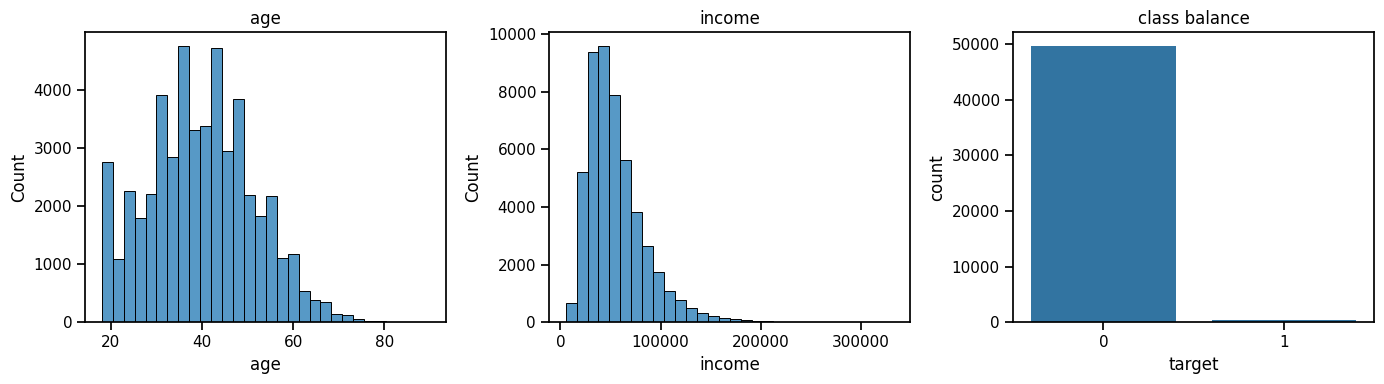

In [4]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.histplot(df['age'], bins=30, ax=axes[0]); axes[0].set_title('age')
sns.histplot(df['income'], bins=30, ax=axes[1]); axes[1].set_title('income')
sns.countplot(x='target', data=df, ax=axes[2]); axes[2].set_title('class balance')
plt.tight_layout(); plt.show()

## 4. Simple Random Sampling (SRS)
We’ll take a **5% sample** (without replacement) and compare means/proportions to the full data.

In [5]:
srs = df.sample(frac=0.05, replace=False, random_state=42)
compare = pd.DataFrame({
    'full_mean':[df['age'].mean(), df['income'].mean(), df['visits'].mean(), df['target'].mean()],
    'srs_mean':[srs['age'].mean(), srs['income'].mean(), srs['visits'].mean(), srs['target'].mean()]
}, index=['age','income','visits','target_rate']).round(4)
compare

,full_mean,srs_mean
age,39.6755,39.5720
income,55639.8549,55250.0204
visits,3.5099,3.4972
target_rate,0.0081,0.0044


### With replacement (rarely needed for fixed‑size datasets)
Sampling **with** replacement allows selecting the same record multiple times. Useful in methods like **bootstrap**.

In [6]:
srs_wr = df.sample(n=2500, replace=True, random_state=123)
srs_wr.shape, srs_wr['target'].mean().round(4)

((2500, 4), np.float64(0.0044))

## 5. Stratified Sampling (preserve class proportions)
If target classes are imbalanced, random sampling can drift from the true proportion. **Stratified** sampling keeps proportions for each class.

In [7]:
# take a 5% stratified sample by 'target'
def stratified_sample(df, by, frac, seed=42):
    parts = []
    for g, grp in df.groupby(by):
        parts.append(grp.sample(frac=frac, replace=False, random_state=seed))
    return pd.concat(parts).sample(frac=1, random_state=seed).reset_index(drop=True)

strat = stratified_sample(df, by='target', frac=0.05)
df['target'].mean().round(4), srs['target'].mean().round(4), strat['target'].mean().round(4)

(np.float64(0.0081), np.float64(0.0044), np.float64(0.008))

### Visual check: class proportions in samples vs full

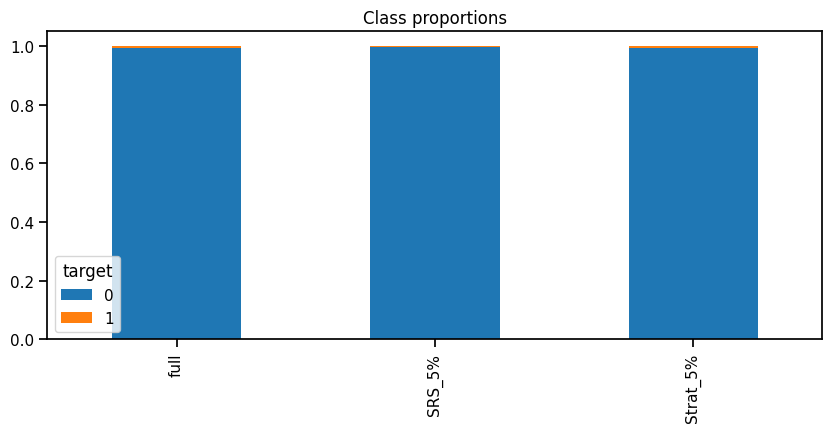

target,0,1
full,0.9919,0.0081
SRS_5%,0.9956,0.0044
Strat_5%,0.9920,0.0080


In [8]:
props = pd.DataFrame({
    'full': df['target'].value_counts(normalize=True),
    'SRS_5%': srs['target'].value_counts(normalize=True),
    'Strat_5%': strat['target'].value_counts(normalize=True)
}).T
props.plot(kind='bar', stacked=True, title='Class proportions'); plt.legend(title='target'); plt.show()
props.round(4)

## 6. Does sampling change model results?
We’ll train a simple logistic regression on (a) full data and (b) a 10% stratified sample and compare accuracy on a **held‑out test set** from the full data.

In [9]:
X = df[['age','income','visits']]; y = df['target']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=7, stratify=y)
# full‑data model
clf_full = LogisticRegression(max_iter=500).fit(X_tr, y_tr)
pred_full = clf_full.predict(X_te)
acc_full = accuracy_score(y_te, pred_full)
# 10% stratified sample of the TRAIN split
train_df = pd.concat([X_tr, y_tr], axis=1)
train_strat = stratified_sample(train_df, by='target', frac=0.10)
clf_samp = LogisticRegression(max_iter=500).fit(train_strat[['age','income','visits']], train_strat['target'])
pred_samp = clf_samp.predict(X_te)
acc_samp = accuracy_score(y_te, pred_samp)
acc_full, acc_samp, len(train_df), len(train_strat)

(0.99216, 0.99208, 37500, 3750)

**Interpretation:** The sampled model trains faster (fewer rows) and may reach **similar accuracy** if the sample is representative. Differences are expected due to sampling variability.

## 7. How big should the sample be? (rule‑of‑thumb check)
For a proportion \(p\), the standard error of an SRS estimate is roughly \(\sqrt{p(1-p)/n}\). Larger **n** lowers uncertainty. Below is a small check that estimates the margin‑of‑error (MOE) at 95% for different sample sizes.

In [10]:
p = df['target'].mean()
sizes = np.array([500, 1000, 2500, 5000, 10000])
se = np.sqrt(p*(1-p)/sizes)
moe95 = 1.96*se
pd.DataFrame({'n':sizes, 'approx_MOE_95_for_target_rate':moe95}).round(4)

,n,approx_MOE_95_for_target_rate
0,500,0.0079
1,1000,0.0056
2,2500,0.0035
3,5000,0.0025
4,10000,0.0018


> **Note:** For very large populations, the finite population correction is small. In practice, use domain constraints (time/memory) + a quick MOE calculation to choose a sample size that’s ‘good enough’.

## 8. Practical checklist
- Set a **random seed** so results are reproducible.
- When doing ML, sample the **training set only**; keep validation/test untouched to avoid leakage.
- Use **stratification** when classes or key segments are rare.
- For streaming/big data, consider **reservoir sampling** (not shown) to sample without knowing the total size.
- Always **compare** sample stats to the full dataset to catch drift.

## 9. Practice exercises
1. Increase the SRS fraction from 5% to 15%. How do the means and class rate change?
2. Try a 20% **non‑stratified** sample for training and compare accuracy to the stratified 10% model.
3. Write a function `reservoir_sample(stream, k)` (conceptual) and test it on a generated sequence.
4. Sample **by time windows** (e.g., last 2 months) and discuss bias risks vs. random sampling.
5. Replace Logistic Regression with a tree model and check how sampling level affects performance.

---
_Last updated: 2026-02-17 20:58:41 UTC_
